# MIP Simulation

Here we calculate the sound created by minimum ionizing particles by using PyPhonon.

In [1]:
# Import libraries
import os
from pyphonon import *
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [2]:
# Simulator parameters
max_order   = 1
n_cores     = 10
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 1
Assembling the estimator using multiprocessing on 10 cores
Permuations created successfully
	Send the fast data to the pool
	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 1, 1 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/3 [00:00<?, ?it/s]

Estimator Generated Successfully
WARNING! Since you are using GPU accelleration you need to check that your input satisfies these conditions z < v t and (z-v t)^2 > r^2 (v^2 - 1). Otherwise there will be errors


In [47]:
# Create some additional helper functions

# Get the fast particle waves as a function of R
def get_params(r:float,v:float,T = np.array([-.1,.1]),N_pts:int=10000,GPU=GPU):
    g = 1/(v**2-1)**0.5
    z = r*g
    T = T - (r**2 + z**2)**0.5
    if GPU: t = cp.linspace(*T,N_pts)
    else: t = np.linspace(*T,N_pts)
    
    return r,z,t,v

# Calculate the average peak and FWHM
def get_peak(p,t,rel_height:float=0.8):
    peaks,_ = find_peaks(abs(p))
    results = peak_widths(abs(p),peaks,rel_height=rel_height)
    if len(peaks) == 0:
        return 0,0

    # Calculate the average width
    avg_width   = np.mean(results[0])*(t[1]-t[0])
    peak        = np.max(p[peaks])

    return peak,avg_width

# For a range of distances find the maximum
def sweep_r(R=np.linspace(0.1,100,100),v=3.0,l=2e-5,GPU=GPU):
    # Empty array to store the maxima over all the R's
    maxima  = []
    FWHM    = []

    # For each radius
    for rr in tqdm(R,desc='Radius GPU: '+str(GPU),leave=False):
        r,z,t,v = get_params(rr,v,T = np.array([-.05,.0])/v)
        p = E(r,z,t,v,l)

        # Calculate the peaks and FWHM
        if GPU: peak, avg_width = get_peak(p.get(),t.get())
        else: peak, avg_width = get_peak(p,t)

        # Append them to the appropriate arrays
        maxima.append(peak)
        FWHM.append(avg_width)

    return maxima,FWHM


# Given an array of velocities and radii predict the maxima for the supersonic speed
def get_width_max(V,R,l):
    pressure_max = []
    pressure_wid = []

    # Now do this for a range of velocities
    for v in tqdm(V,desc='Velocities'):
        MAX,WID = sweep_r(R,v,l)
        pressure_max.append(MAX)
        pressure_wid.append(WID)
        
    # Return the pressure maxima and average width
    return pressure_max,pressure_wid


# Create a figure of these measurements
def plot_pressure(V,R,pressure_max,pressure_wid):
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Plot all the thingys
    for v,pressure,width in zip(V,pressure_max,pressure_wid):
        ax1.plot(R,pressure,label=r'$v=%.1f$'%(v))
        ax2.plot(R,width,label=r'$v=%.1f$'%(v))

    # Add a legend
    ax1.legend(frameon=False)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.legend(frameon=False)
    ax2.set_yscale('log')
    ax2.set_xscale('log')

In [48]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

In [56]:
# Calculate 
V = np.linspace(0.6e8/fluids[0].sound_speed,0.8e8/fluids[0].sound_speed,3)
R = 10**np.linspace(-4,0,100)

pressure_max, pressure_wid = get_width_max(V,R,fluids[0].viscosity_coefficient()*fluids[0].sound_speed)

Velocities:   0%|          | 0/3 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


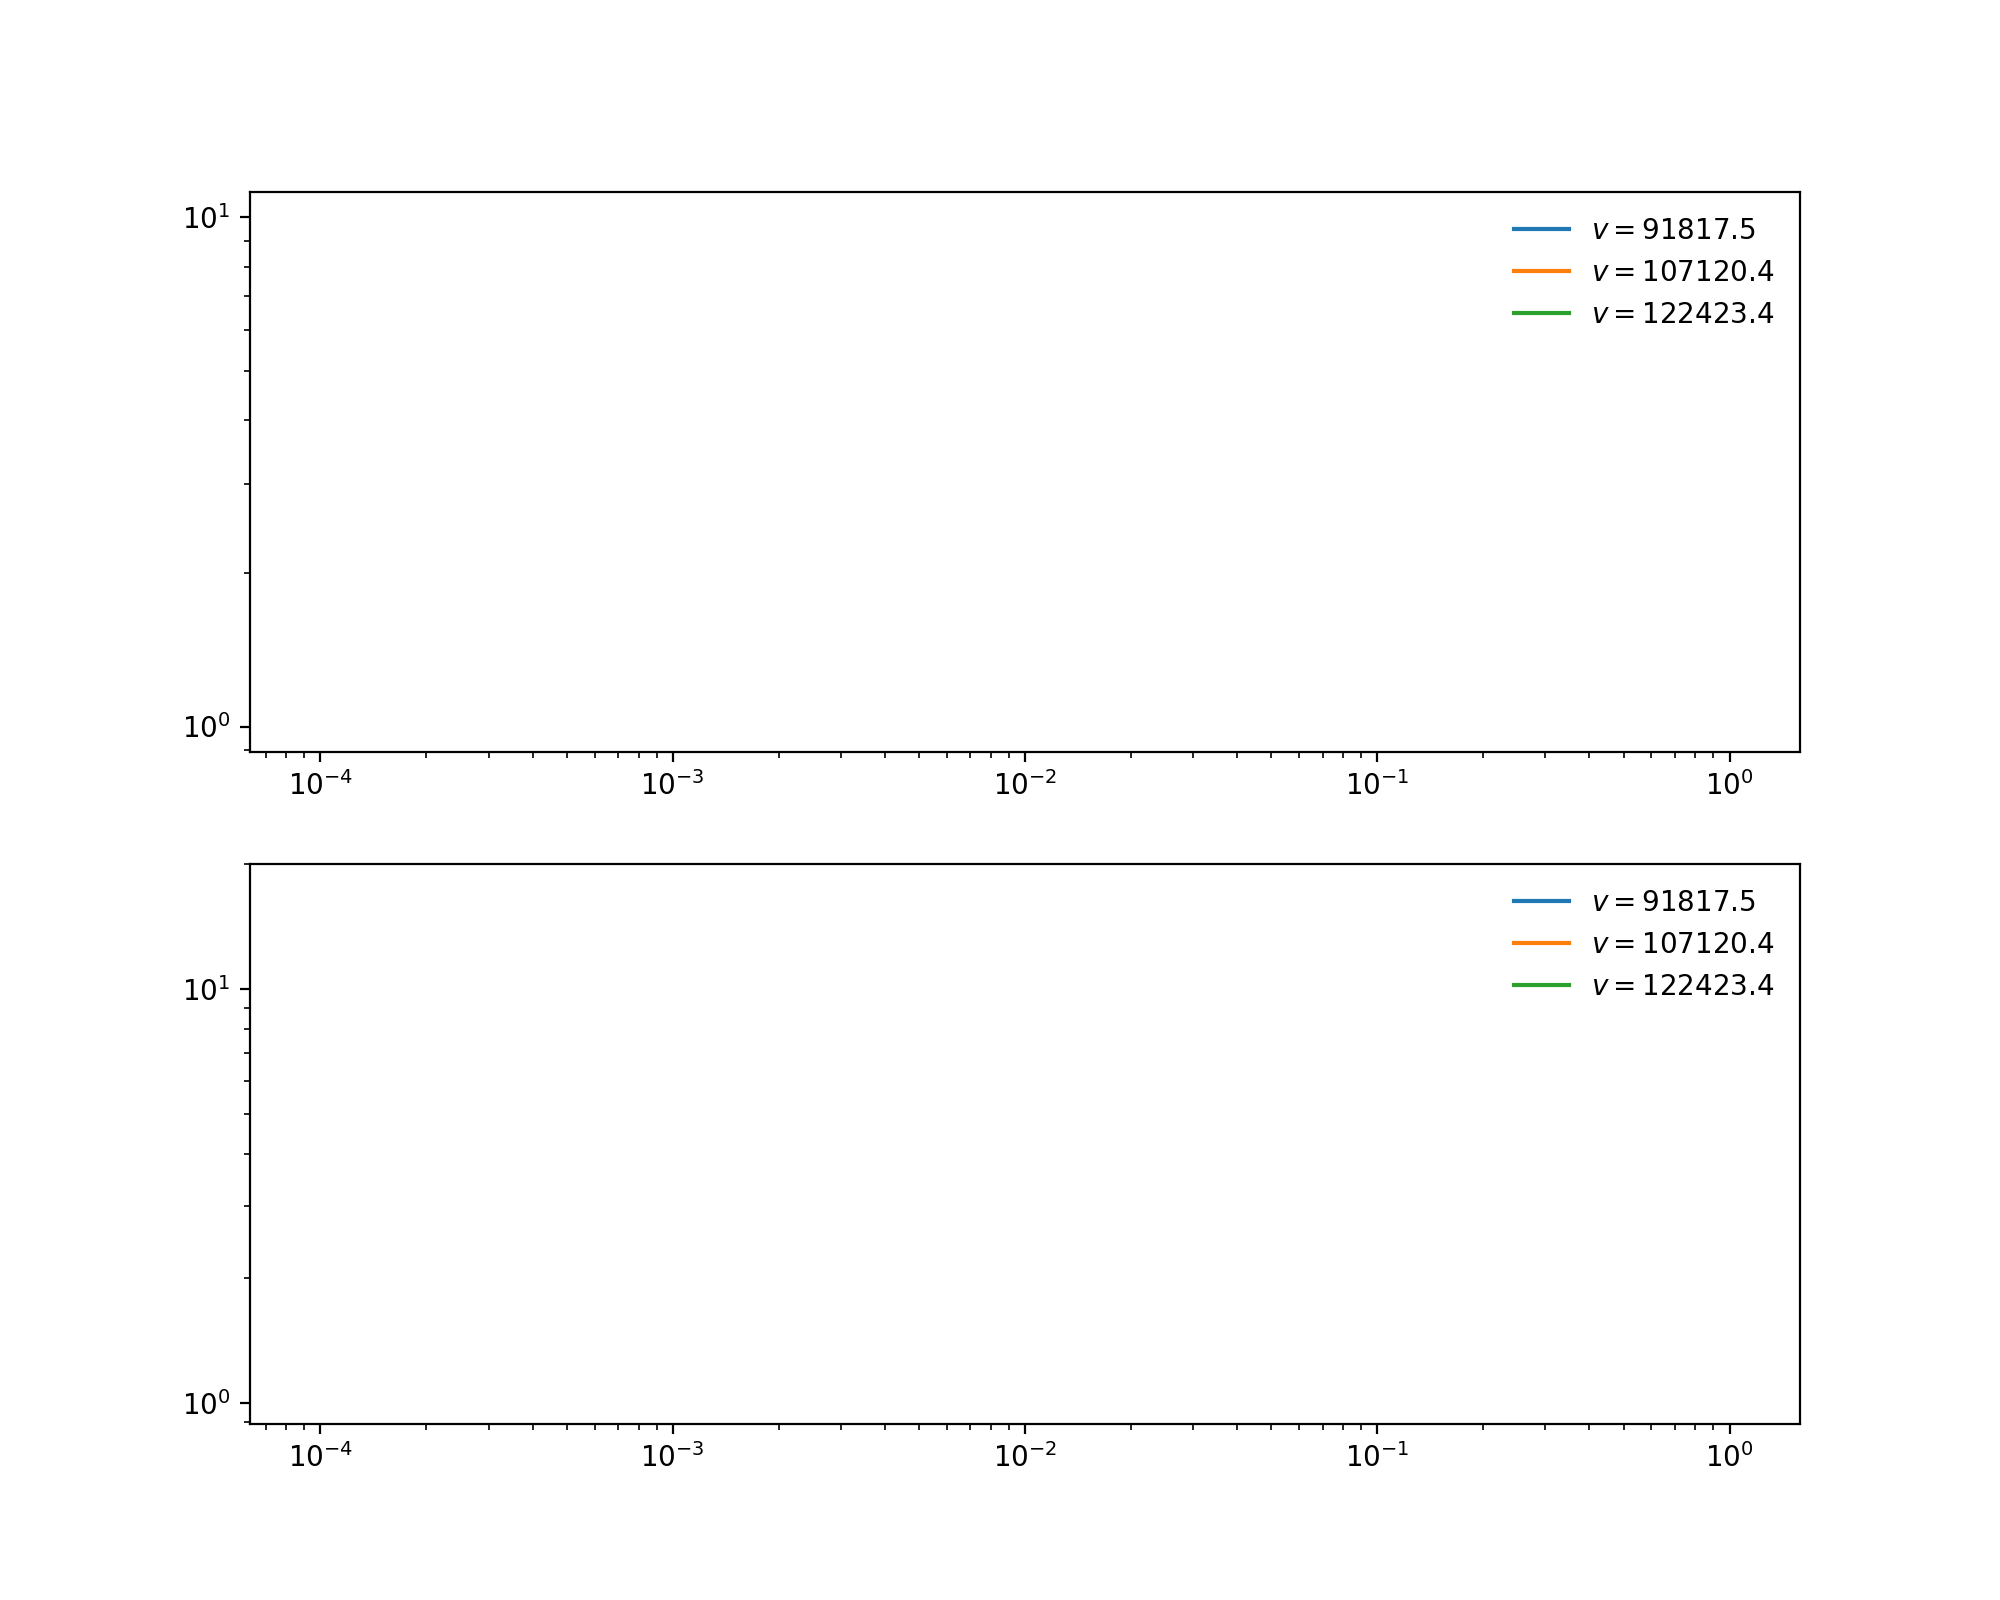

In [57]:
# Plot them
plot_pressure(V,R,pressure_max,pressure_wid)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[-1.18893978e+39 -1.18893978e+39 -1.18893978e+39 ... -2.50815356e+52
 -2.50815356e+52 -2.50815356e+52]


<IPython.core.display.Javascript object>


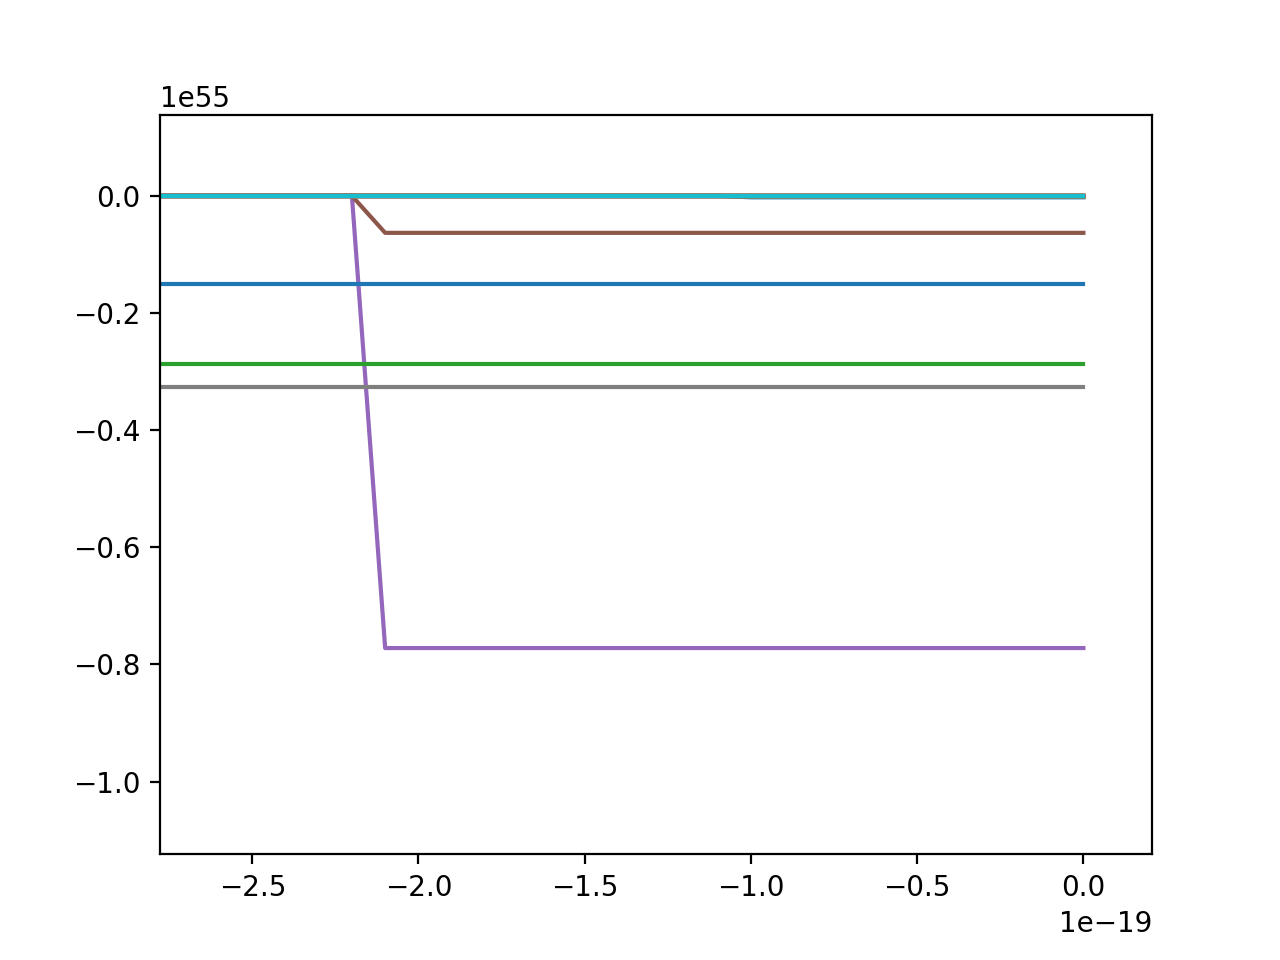

[-8.67679416e+38 -8.67679416e+38 -8.67679416e+38 ... -4.01352860e+50
 -4.01352860e+50 -4.01352860e+50]
[-6.66325272e+38 -6.66325272e+38 -6.66325272e+38 ... -1.41445371e+52
 -1.41445371e+52 -1.41445371e+52]


  0%|          | 0/3 [00:00<?, ?it/s]

[-2.56288569e+39 -2.56288569e+39 -2.56288569e+39 ... -3.06078933e+50
 -3.06078933e+50 -3.06078933e+50]
[-1.88591301e+39 -1.88591301e+39 -1.88591301e+39 ... -7.72094057e+54
 -7.72094057e+54 -7.72094057e+54]
[-1.45589489e+39 -1.45589489e+39 -1.45589489e+39 ... -6.31795393e+53
 -6.31795393e+53 -6.31795393e+53]


  0%|          | 0/3 [00:00<?, ?it/s]

[-5.52430610e+39 -5.52430610e+39 -5.52430610e+39 ... -9.35893913e+48
 -9.35893913e+48 -9.35893913e+48]
[-4.20407725e+39 -4.20407725e+39 -4.20407725e+39 ... -4.00314198e+47
 -4.00314198e+47 -4.00314198e+47]
[-3.13760541e+39 -3.13760541e+39 -3.13760541e+39 ... -3.27167727e+57
 -3.27167727e+57 -3.27167727e+57]


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.17070676e+40 -1.17070676e+40 -1.17070676e+40 ... -5.62605453e+48
 -5.62605453e+48 -5.62605453e+48]
[-8.82770253e+39 -8.82770253e+39 -8.82770253e+39 ... -1.50757313e+54
 -1.50757313e+54 -1.50757313e+54]
[-6.61866986e+39 -6.61866986e+39 -6.61866986e+39 ... -2.55474870e+51
 -2.55474870e+51 -2.55474870e+51]


  0%|          | 0/3 [00:00<?, ?it/s]

[-2.48327636e+40 -2.48327636e+40 -2.48327636e+40 ... -2.86338085e+54
 -2.86338085e+54 -2.86338085e+54]
[-1.85892534e+40 -1.85892534e+40 -1.85892534e+40 ... -2.25783677e+47
 -2.25783677e+47 -2.25783677e+47]
[-1.38455259e+40 -1.38455259e+40 -1.38455259e+40 ... -3.47665553e+50
 -3.47665553e+50 -3.47665553e+50]


  0%|          | 0/3 [00:00<?, ?it/s]

[-4.64888921e+40 -4.64888921e+40 -4.64888921e+40 ... -1.08390360e+48
 -1.08390360e+48 -1.08390360e+48]
[-3.93699617e+40 -3.93699617e+40 -3.93699617e+40 ... -9.80809984e+46
 -9.80809984e+46 -9.80809984e+46]
[-4.06259885e+40 -4.06259885e+40 -4.06259885e+40 ... -3.27167766e+54
 -3.27167766e+54 -3.27167766e+54]


  0%|          | 0/3 [00:00<?, ?it/s]

[-1.23630336e+41 -1.23630336e+41 -1.23630336e+41 ... -1.67992521e+46
 -1.67992521e+46 -1.67992521e+46]
[-1.01474738e+41 -1.01474738e+41 -1.01474738e+41 ... -2.28440361e+45
 -2.28440361e+45 -2.28440361e+45]
[-5.05371885e+40 -5.05371885e+40 -5.05371885e+40 ... -6.73720069e+45
 -6.73720069e+45 -6.73720069e+45]


  0%|          | 0/3 [00:00<?, ?it/s]

[-3.82249462e+41 -3.82249462e+41 -3.82249462e+41 ... -1.02459798e+44
 -1.02459798e+44 -1.02459798e+44]
[-1.92992337e+41 -1.92992337e+41 -1.92992337e+41 ... -3.79036040e+47
 -3.79036040e+47 -3.79036040e+47]
[-7.85365194e+40 -7.85365194e+40 -7.85365194e+40 ... -2.12529962e+43
 -2.12529962e+43 -2.12529962e+43]


  0%|          | 0/3 [00:00<?, ?it/s]

[-2.39738642e+42 -2.39738642e+42 -2.39738642e+42 ... -7.03889904e+45
 -7.03889904e+45 -7.03889904e+45]
[-1.00983756e+42 -1.00983756e+42 -1.00983756e+42 ... -2.66759840e+44
 -2.66759840e+44 -2.66759840e+44]
[-3.01928492e+41 -3.01928492e+41 -3.01928492e+41 ... -2.37332340e+44
 -2.37332340e+44 -2.37332340e+44]


  0%|          | 0/3 [00:00<?, ?it/s]

[-3.71320417e+45 -3.71320417e+45 -3.71320417e+45 ... -3.71320417e+45
 -3.71320417e+45 -3.71320417e+45]
[-1.66643745e+45 -1.66643745e+45 -1.66643745e+45 ... -1.66643745e+45
 -1.66643745e+45 -1.66643745e+45]
[-6.56925092e+50 -6.56925092e+50 -6.56925092e+50 ... -6.56925092e+50
 -6.56925092e+50 -6.56925092e+50]


In [68]:
R = 10**np.linspace(-3,0,10)
l = fluids[0].viscosity_coefficient()*fluids[0].sound_speed
T = np.array([-1e-16,0])
N_pts= 10000

c=0
for rr in tqdm(R):
    for v in tqdm(V,leave=False):
        r,z,t,v = get_params(rr,v,T=T,N_pts=N_pts)
        p = E(r,z,t,v,l)
        print(p)

        plt.plot(np.linspace(*T,N_pts),p.get()+0.5*c)
#         plt.ylim(0,20)
        c+=1

In [59]:
# %matplotlib notebook
pressure_max

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]